Summary of the features we're keeping to run this iteration.  Here are our splits:
# 
| Feature Group | Features |
|--------------|----------|
| ~~Quantified Metrics~~  | ~~impressions, clicks, CTR (to create), AverageWinPrice (CPM)~~ |
| Channel & Location    | channel, country, os, networkType, deviceType, CTR (to create), AverageWinPrice (CPM) |
| ~~Quantified with Date & Profit~~        | ~~impressions, clicks, date, CTR (to create), AverageWinPrice (CPM), rate~~ |
| Advertiser & Product     | advMaturity, publisherCategory, advertiserCategory, product, subProduct, campaign, AverageWinPrice (CPM) |

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels openpyxl scipy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

### Data Orientation

In [3]:
# split excel into multiple sheets
excel_file = 'data/raw/data.xlsx'
dir_name = 'data/raw'
xls = pd.ExcelFile(excel_file)

# load each sheet into a document
# Not overwrite
for sheet_name in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    csv_file = f"{dir_name}/{sheet_name.replace(' ', '_')}.csv"
    df.to_csv(csv_file, index=False)
    print(f"Saved sheet: {sheet_name}")


Saved sheet: historical data
Saved sheet: data_to_predict


In [4]:
# let's take a look at the data
historical_df = pd.read_csv('data/raw/historical_data.csv')
historical_df.head()


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
0,9,0,2017-12-09,inr,AU,android,3g,mobile,game_arcade,entertainment,600775.0,NaN,301059092,NaN,low maturity,1.404217,0.140000
1,6,0,2017-12-09,inr,ES,android,3g,mobile,game_casual,game_educational,640029.0,com.mohitdev.minebuild,300208158,NaN,low maturity,0.575850,0.030000
2,57,0,2017-12-09,inr,FR,android,3g,mobile,game_word,game_action,618417.0,com.etermax.apalabrados.lite,300038580,NaN,low maturity,0.052181,0.017333
3,22,2,2017-12-09,inr,IT,android,3g,mobile,game_adventure,entertainment,631206.0,com.secg.robocraft,301068023,NaN,low maturity,0.265992,0.021000
4,3,0,2017-12-09,inr,IT,android,3g,mobile,game_arcade,entertainment,632417.0,com.craftpixelstudio.cubelands,300222537,NaN,low maturity,0.676667,0.035000


In [5]:
# let's take a statistical summary of the data
historical_df.describe(include='all')


,impressions,clicks,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,AverageWinPrice (CPM),rate
count,304629.000000,304629.000000,304629,304629,304618,304629,304629,304629,253895,299908,2.400300e+05,251823,302951,76388,304628,304629.000000,304629.000000
unique,NaN,NaN,8,5,53,2,4,2,47,38,NaN,875,370,65,12,NaN,NaN
top,NaN,NaN,2017-12-11,mpb,ZA,android,3g,mobile,game_puzzle,entertainment,NaN,1075264954,300798390,com.p74.player,low maturity,NaN,NaN
freq,NaN,NaN,40739,172588,48404,281007,204345,295987,31406,139492,NaN,2779,7335,10025,187226,NaN,NaN
mean,88.306632,0.761815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.370810e+08,NaN,NaN,NaN,NaN,0.207046,0.027231
std,1193.871334,12.364807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.842803e+08,NaN,NaN,NaN,NaN,0.332051,0.027564
min,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627600e+04,NaN,NaN,NaN,NaN,0.007190,0.003000
25%,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.872324e+06,NaN,NaN,NaN,NaN,0.050000,0.011000
50%,5.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.058059e+08,NaN,NaN,NaN,NaN,0.105240,0.020000
75%,21.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.219066e+09,NaN,NaN,NaN,NaN,0.207143,0.030000


In [6]:
data_to_predict_df = pd.read_csv('data/raw/data_to_predict.csv')
data_to_predict_df.head()

,sessionId,eDate,channel,country,os,networkType,deviceType,publisherCategory,advertiserCategory,product,subProduct,campaign,advPackage,advMaturity,rate
0,9705699729732200,2017-12-17,smt,BR,ios,unknown,mobile,NaN,education,130000706,319881193,301604736,com.kawecki.onemind,4+,0.010
1,12802690671750800,2017-12-17,smt,KH,android,3g,mobile,music & audio,entertainment,130167110,com.fundevs.app.mediaconverter,300988528,NaN,low maturity,0.008
2,21347409150256300,2017-12-17,smt,ID,ios,not_wifi,mobile,NaN,travel,130285027,com.alcaydevs.idlfree,300228923,com.go-jek.ios,4+,0.020
3,23329125091887800,2017-12-17,inr,RU,android,3g,mobile,social,music & audio,625569,drug.vokrug,301060338,com.p74.player,parental guidance,0.022
4,28266843791174100,2017-12-17,smt,DE,android,wifi,mobile,photography,NaN,130356465,com.photo.editor.cartoon,301011313,NaN,everyone,0.025


In [7]:
# dataframe dimensions
print(f"This dataframe has {historical_df.shape[0]} rows and {historical_df.shape[1]} columns.")
historical_df.info()

This dataframe has 304629 rows and 17 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304629 entries, 0 to 304628
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   impressions            304629 non-null  int64  
 1   clicks                 304629 non-null  int64  
 2   eDate                  304629 non-null  object 
 3   channel                304629 non-null  object 
 4   country                304618 non-null  object 
 5   os                     304629 non-null  object 
 6   networkType            304629 non-null  object 
 7   deviceType             304629 non-null  object 
 8   publisherCategory      253895 non-null  object 
 9   advertiserCategory     299908 non-null  object 
 10  product                240030 non-null  float64
 11  subProduct             251823 non-null  object 
 12  campaign               302951 non-null  object 
 13  advPackage             76388 non-null   ob

In [8]:
# let's look at the distribution of our categorical variables
for column in historical_df.columns:
    if historical_df[column].dtype == 'object':
        print(f"Distribution of {column}:")
        print(historical_df[column].value_counts())
        print("\n")


Distribution of eDate:
eDate
2017-12-11    40739
2017-12-13    39743
2017-12-16    39000
2017-12-12    38743
2017-12-14    38546
2017-12-09    37791
2017-12-10    36090
2017-12-15    33977
Name: count, dtype: int64


Distribution of channel:
channel
mpb    172588
inr     72340
smt     49929
nxg      9495
rub       277
Name: count, dtype: int64


Distribution of country:
country
ZA    48404
JP    46055
ES    27456
RU    26017
PL    17768
FR    11087
IT     9515
BR     9087
MM     8869
AE     8582
US     5925
AU     5829
KR     5520
PA     4926
EG     4125
TN     4115
ID     3853
PT     3754
OM     3407
CL     3230
BH     2932
DE     2930
DZ     2799
GB     2793
MA     2558
NG     2534
HK     2471
KH     2435
VN     2382
KW     2341
TR     2064
NO     1942
MX     1675
RS     1665
NL     1586
IN     1536
SN     1271
DO     1245
SG     1121
PY      962
TH      916
HN      842
CA      738
MY      590
PH      577
AT      551
PK      512
HU      415
QA      247
TW      205
CR      130
SA     

### Visualizing our dataframes and eventual modeling

Predict CTR first, then use these predictions to predict CPM. This approach lets you refine the CTR predictions independently, which may improve the quality of CPM predictions.

If you’re not satisfied with the results, you could then try a multi-target model to see if simultaneous predictions capture hidden correlations better.



In [11]:
#create our CTR feature
historical_df['CTR'] = historical_df['clicks'] / historical_df['impressions']
print(f"The mean CTR is: {historical_df['CTR'].mean():.4%}")


The mean CTR is: 1.5350%


In [12]:
combined_metrics_cols = ['channel', 'country', 'os', 'networkType', 'deviceType', 'advMaturity', 'publisherCategory', 'advertiserCategory', 'product', 'subProduct', 'campaign', 'CTR', 'AverageWinPrice (CPM)']

In [16]:
# wow that's looking alike a mess
unique_counts = historical_df[combined_metrics_cols].nunique()
print("Number of unique values per column:")
print(unique_counts)

Number of unique values per column:
channel                       5
country                      53
os                            2
networkType                   4
deviceType                    2
advMaturity                  12
publisherCategory            47
advertiserCategory           38
product                    1104
subProduct                  875
campaign                    370
CTR                        6642
AverageWinPrice (CPM)    116825
dtype: int64


### Preprocessing & EDA 

Removing outliers, missing values, etc.

Encoding of categorical variables to numbers

Declaring our target features.



In [17]:
# create our new dataframe with our features from channel_metrics_cols
historical_eda_df = historical_df[combined_metrics_cols]
historical_eda_df.head()


,channel,country,os,networkType,deviceType,advMaturity,publisherCategory,advertiserCategory,product,subProduct,campaign,CTR,AverageWinPrice (CPM)
0,inr,AU,android,3g,mobile,low maturity,game_arcade,entertainment,600775.0,NaN,301059092,0.000000,1.404217
1,inr,ES,android,3g,mobile,low maturity,game_casual,game_educational,640029.0,com.mohitdev.minebuild,300208158,0.000000,0.575850
2,inr,FR,android,3g,mobile,low maturity,game_word,game_action,618417.0,com.etermax.apalabrados.lite,300038580,0.000000,0.052181
3,inr,IT,android,3g,mobile,low maturity,game_adventure,entertainment,631206.0,com.secg.robocraft,301068023,0.090909,0.265992
4,inr,IT,android,3g,mobile,low maturity,game_arcade,entertainment,632417.0,com.craftpixelstudio.cubelands,300222537,0.000000,0.676667


In [18]:
# Print data types of each column
print("\nData types of each column:")
historical_eda_df.dtypes



Data types of each column:


channel                   object
country                   object
os                        object
networkType               object
deviceType                object
advMaturity               object
publisherCategory         object
advertiserCategory        object
product                  float64
subProduct                object
campaign                  object
CTR                      float64
AverageWinPrice (CPM)    float64
dtype: object

In [19]:
# missing values summary
def missing_values_summary(df): 
    return pd.DataFrame(
        zip(
            df.columns,
            df.isna().any(),
            (df.isna().sum() / df.shape[0] * 100).round(2),
            df.dtypes,
            df.apply(lambda x: x.sample(n=1).iloc[0] if len(x) > 0 else None)),
        columns=['Column', 'Has Missing Values', '% Missing Values', 'Feature Type', 'Sample Value']
    )

missing_values_summary(historical_eda_df)


,Column,Has Missing Values,% Missing Values,Feature Type,Sample Value
0,channel,False,0.00,object,inr
1,country,True,0.00,object,NG
2,os,False,0.00,object,ios
3,networkType,False,0.00,object,3g
4,deviceType,False,0.00,object,mobile
5,advMaturity,True,0.00,object,low maturity
6,publisherCategory,True,16.65,object,NaN
7,advertiserCategory,True,1.55,object,game_casual
8,product,True,21.21,float64,1845233409.0
9,subProduct,True,17.33,object,NaN


In [20]:
# First, let's see the original row count
print(f"Original row count: {len(historical_eda_df)}")

#  Fill missing values strategically
strategic_df = historical_eda_df.copy()

strategic_df = strategic_df.dropna(subset=['channel'])
strategic_df = strategic_df.dropna(subset=['country'])
strategic_df = strategic_df.dropna(subset=['os'])
strategic_df = strategic_df.dropna(subset=['networkType'])
strategic_df = strategic_df.dropna(subset=['deviceType'])
strategic_df = strategic_df.dropna(subset=['advMaturity'])

strategic_df['publisherCategory'] = strategic_df['publisherCategory'].fillna('UNKNOWN')
strategic_df['advertiserCategory'] = strategic_df['advertiserCategory'].fillna('UNKNOWN')

strategic_df['product'] = strategic_df['product'].fillna('UNKNOWN')
strategic_df['subProduct'] = strategic_df['subProduct'].fillna('UNKNOWN')
strategic_df['campaign'] = strategic_df['campaign'].fillna('UNKNOWN')

print(f"Row count after strategic filling: {len(strategic_df)}")
missing_values_summary(strategic_df)

Original row count: 304629
Row count after strategic filling: 304617


,Column,Has Missing Values,% Missing Values,Feature Type,Sample Value
0,channel,False,0.0,object,mpb
1,country,False,0.0,object,KR
2,os,False,0.0,object,android
3,networkType,False,0.0,object,wifi
4,deviceType,False,0.0,object,mobile
5,advMaturity,False,0.0,object,parental guidance
6,publisherCategory,False,0.0,object,productivity
7,advertiserCategory,False,0.0,object,games
8,product,False,0.0,object,600775.0
9,subProduct,False,0.0,object,com.hideitpro


In [21]:
# let's take our UUIDs and format uniformly
print("Product samples:")
print(strategic_df['product'].head(10))
print("\nSubProduct samples:")
print(strategic_df['subProduct'].head(10))
print("\nCampaign samples:")
print(strategic_df['campaign'].head(10))

# convert each of these features to strings
strategic_df['product'] = strategic_df['product'].astype(str)
strategic_df['subProduct'] = strategic_df['subProduct'].astype(str)
strategic_df['campaign'] = strategic_df['campaign'].astype(str)

def analyze_id_format(series, column_name):
    print(f"\n{column_name} Analysis:")
    print(f"Total unique values: {series.nunique()}")
    print(f"Data type: {series.dtype}")
    
    # Check for different formats
    print("\nSample formats:")
    print(series.value_counts().head())
    
    # Check for potential issues
    print("\nPotential issues:")
    print("NaN values:", series.isna().sum())
    print("Empty strings:", (series == '').sum())
    print("Decimal points:", series.astype(str).str.contains('\.').sum())
    print("Non-numeric:", series.astype(str).str.contains('[^0-9\.]').sum())

analyze_id_format(strategic_df['product'], 'Product')
analyze_id_format(strategic_df['subProduct'], 'SubProduct')
analyze_id_format(strategic_df['campaign'], 'Campaign')



Product samples:
0    600775.0
1    640029.0
2    618417.0
3    631206.0
4    632417.0
5    600775.0
6    605078.0
7     UNKNOWN
8    608474.0
9    602318.0
Name: product, dtype: object

SubProduct samples:
0                           UNKNOWN
1            com.mohitdev.minebuild
2      com.etermax.apalabrados.lite
3                com.secg.robocraft
4    com.craftpixelstudio.cubelands
5                           UNKNOWN
6                   com.mmo.android
7                           UNKNOWN
8          air.hockey.sweetgamesbox
9             com.devexpert.weather
Name: subProduct, dtype: object

Campaign samples:
0    301059092
1    300208158
2    300038580
3    301068023
4    300222537
5    300222537
6    301068023
7    300222537
8    301044597
9    300659871
Name: campaign, dtype: object

Product Analysis:
Total unique values: 1105
Data type: object

Sample formats:
product
UNKNOWN        64591
600775.0        5500
130006611.0     3563
630535.0        2205
65850401.0      1597
Name: cou

In [23]:
# Clean and standardize format
def standardize_id(series):
    # Convert to string
    series = series.astype(str)
    
    # Remove decimal points (if any)
    series = series.str.replace('.0', '', regex=False)
    
    # Replace NaN/empty with placeholder
    series = series.replace(['nan', 'NaN', '', 'None'], 'UNKNOWN')
    
    return series

# Apply standardization
strategic_df['product_clean'] = standardize_id(strategic_df['product'])
strategic_df['subProduct_clean'] = standardize_id(strategic_df['subProduct'])
strategic_df['campaign_clean'] = standardize_id(strategic_df['campaign'])

# Verify results
print("\nAfter cleaning:")
print("\nProduct samples:")
print(strategic_df['product_clean'].head())
print("\nSubProduct samples:")
print(strategic_df['subProduct_clean'].head())
print("\nCampaign samples:")
print(strategic_df['campaign_clean'].head())

#drop the original product, subProduct, and campaign columns
strategic_df = strategic_df.drop(columns=['product', 'subProduct', 'campaign'])
combined_metrics_cols = ['channel', 'country', 'os', 'networkType', 'deviceType', 'advMaturity', 'publisherCategory', 'advertiserCategory', 'product_clean', 'subProduct_clean', 'campaign_clean', 'CTR', 'AverageWinPrice (CPM)']



After cleaning:

Product samples:
0    600775
1    640029
2    618417
3    631206
4    632417
Name: product_clean, dtype: object

SubProduct samples:
0                           UNKNOWN
1            com.mohitdev.minebuild
2      com.etermax.apalabrados.lite
3                com.secg.robocraft
4    com.craftpixelstudio.cubelands
Name: subProduct_clean, dtype: object

Campaign samples:
0    301059092
1    300208158
2    300038580
3    301068023
4    300222537
Name: campaign_clean, dtype: object


In [24]:
# here is where we will pass in our different tiny-dataframes into our created methods for visualization
strategic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CTR,304617.0,0.015348,0.089512,0.00000,0.00,0.00000,0.000000,1.00000
AverageWinPrice (CPM),304617.0,0.207051,0.332056,0.00719,0.05,0.10524,0.207143,12.64182


In [25]:
# Check for any obvious errors or outliers
for col in strategic_df.columns:
    print(f"\n{col} - sample values:")
    print(strategic_df[col].value_counts().head())


channel - sample values:
channel
mpb    172587
inr     72340
smt     49929
nxg      9495
rub       266
Name: count, dtype: int64

country - sample values:
country
ZA    48404
JP    46055
ES    27456
RU    26017
PL    17768
Name: count, dtype: int64

os - sample values:
os
android    280995
ios         23622
Name: count, dtype: int64

networkType - sample values:
networkType
3g          204344
wifi         56354
not_wifi     32924
unknown      10995
Name: count, dtype: int64

deviceType - sample values:
deviceType
mobile    295975
tablet      8642
Name: count, dtype: int64

advMaturity - sample values:
advMaturity
low maturity         187224
everyone              33151
pegi 3                24925
parental guidance     15207
pegi 12               14079
Name: count, dtype: int64

publisherCategory - sample values:
publisherCategory
UNKNOWN          50726
game_puzzle      31406
game_casual      22876
entertainment    16693
game_action      15188
Name: count, dtype: int64

advertiserCatego

### Seems like we have all of our data cleaned and ready for encoding and modeling

In [26]:
# Categorical Encoding
# Define a function to perform target encoding
def target_encode(df, target_col, category_col):
    mean_target = df.groupby(category_col)[target_col].mean()
    df[category_col + '_encoded'] = df[category_col].map(mean_target)
    return df

In [27]:
# Create a copy of the dataframe for CTR analysis
ctr_df = strategic_df.copy()
ctr_df = ctr_df.dropna(subset=strategic_df.columns)

for col in ctr_df.columns:
    train_data = target_encode(ctr_df, 'CTR', col)
    train_data = target_encode(ctr_df, 'AverageWinPrice (CPM)', col)  

# drop the original advertiser & product columns
X = train_data.drop(columns=combined_metrics_cols)
X = X.drop(columns=['CTR_encoded', 'AverageWinPrice (CPM)_encoded'])

y = train_data[['CTR_encoded', 'AverageWinPrice (CPM)_encoded']]

X.head()

,channel_encoded,country_encoded,os_encoded,networkType_encoded,deviceType_encoded,advMaturity_encoded,publisherCategory_encoded,advertiserCategory_encoded,product_clean_encoded,subProduct_clean_encoded,campaign_clean_encoded
0,0.257611,0.480528,0.216265,0.216783,0.207289,0.199133,0.226699,0.223634,0.183729,0.181598,0.643322
1,0.257611,0.186420,0.216265,0.216783,0.207289,0.199133,0.366860,0.160507,0.491654,0.335028,0.184772
2,0.257611,0.215790,0.216265,0.216783,0.207289,0.199133,0.170109,0.142369,0.058438,0.073384,0.271474
3,0.257611,0.222408,0.216265,0.216783,0.207289,0.199133,0.344861,0.223634,0.352754,0.236854,0.176314
4,0.257611,0.222408,0.216265,0.216783,0.207289,0.199133,0.226699,0.223634,0.283370,0.502179,0.279278


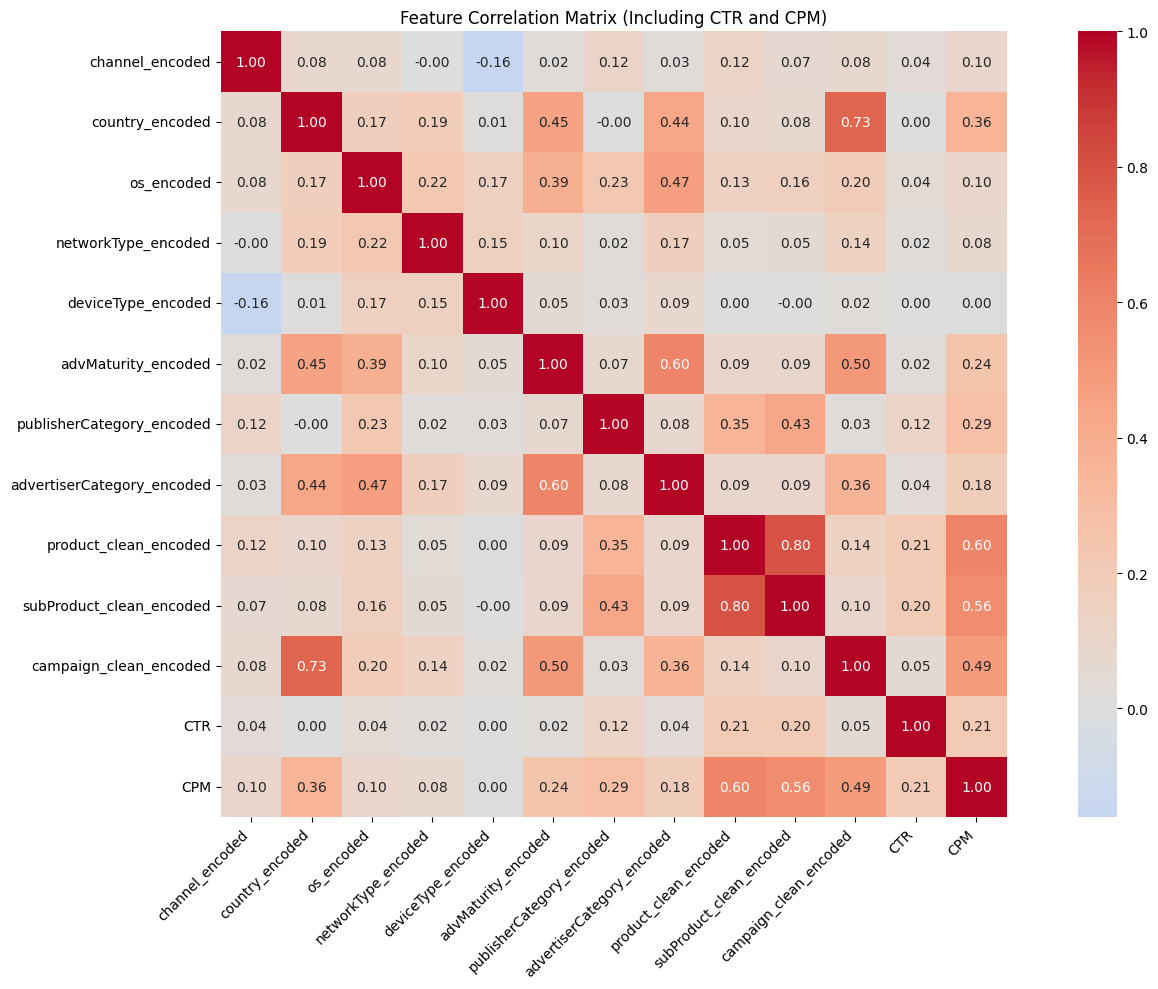


Correlations with CTR:
CTR                           1.000000
CPM                           0.210734
product_clean_encoded         0.206595
subProduct_clean_encoded      0.200123
publisherCategory_encoded     0.124375
campaign_clean_encoded        0.049597
os_encoded                    0.042309
channel_encoded               0.038864
advertiserCategory_encoded    0.036470
networkType_encoded           0.024404
advMaturity_encoded           0.018803
country_encoded               0.001185
deviceType_encoded            0.000679
Name: CTR, dtype: float64

Correlations with CPM:
CPM                           1.000000
product_clean_encoded         0.595801
subProduct_clean_encoded      0.557526
campaign_clean_encoded        0.485176
country_encoded               0.357641
publisherCategory_encoded     0.288183
advMaturity_encoded           0.244895
CTR                           0.210734
advertiserCategory_encoded    0.177393
channel_encoded               0.096394
os_encoded                   

In [31]:
# Create a DataFrame that includes both features and targets
correlation_df = X.copy()
correlation_df['CTR'] = y['CTR_encoded']
correlation_df['CPM'] = y['AverageWinPrice (CPM)_encoded']

# Create correlation matrix
correlation_matrix = correlation_df.corr()

# Create a larger figure for better readability
plt.figure(figsize=(15, 10))

# Create heatmap with modified parameters
sns.heatmap(correlation_matrix, 
            annot=True,           
            cmap='coolwarm',      
            center=0,             
            fmt='.2f',
            square=True)          # Make cells square for better visualization

plt.title('Feature Correlation Matrix (Including CTR and CPM)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optionally, print the correlations with CTR and CPM specifically
print("\nCorrelations with CTR:")
print(correlation_matrix['CTR'].sort_values(ascending=False))
print("\nCorrelations with CPM:")
print(correlation_matrix['CPM'].sort_values(ascending=False))

In [34]:
!pip install xgboost
from xgboost import XGBRegressor


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [35]:
# Stratified samplign for cross validation
from sklearn.multioutput import MultiOutputRegressor

# Create bins for CTR (our target variable) since StratifiedKFold requires categorical labels
# We bin it because CTR is continuous and StratifiedKFold needs discrete categories
y_binned = pd.qcut(y['CTR_encoded'], q=5, labels=False, duplicates='drop')  

base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, objective="reg:squarederror")
multi_target_model = MultiOutputRegressor(base_model)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mse_scores_ctr = []
mse_scores_cpm = []
r2_scores_ctr = []
r2_scores_cpm = []

# Multi-Target Modeling with Cross-Validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X, y_binned)):
    print(f"Fold {fold_num + 1}")
    
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]

    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Init multi-target model
    multi_target_model.fit(X_train_fold, y_train_fold)
    y_pred = multi_target_model.predict(X_test_fold)

    # Calculate MSE and R² for CTR and CPM separately
    mse_ctr = mean_squared_error(y_test_fold['CTR_encoded'], y_pred[:, 0])
    mse_cpm = mean_squared_error(y_test_fold['AverageWinPrice (CPM)_encoded'], y_pred[:, 1])
    mse_scores_ctr.append(mse_ctr)
    mse_scores_cpm.append(mse_cpm)
    
    r2_ctr = r2_score(y_test_fold['CTR_encoded'], y_pred[:, 0])
    r2_cpm = r2_score(y_test_fold['AverageWinPrice (CPM)_encoded'], y_pred[:, 1])
    r2_scores_ctr.append(r2_ctr)
    r2_scores_cpm.append(r2_cpm)

    print(f"Training size: {len(X_train_fold)}, Validation size: {len(X_test_fold)}")
    print(f"Average CTR in training: {y_train_fold['CTR_encoded'].mean():.4f}")
    print(f"Average CTR in validation: {y_test_fold['CTR_encoded'].mean():.4f}")
    print(f"Average CPM in training: {y_train_fold['AverageWinPrice (CPM)_encoded'].mean():.4f}")
    print(f"Average CPM in validation: {y_test_fold['AverageWinPrice (CPM)_encoded'].mean():.4f}")
    print("\n")

#Calculate average cross-validation scores
print("Average Cross-Validation Scores:")
print(f"Average MSE for CTR: {np.mean(mse_scores_ctr):.4f}")
print(f"Average R2 for CTR: {np.mean(r2_scores_ctr):.4f}")
print('\n')
print(f"Average MSE for CPM: {np.mean(mse_scores_cpm):.4f}")
print(f"Average R2 for CPM: {np.mean(r2_scores_cpm):.4f}")



Fold 1
Training size: 243693, Validation size: 60924
Average CTR in training: 0.2071
Average CTR in validation: 0.2069
Average CPM in training: 0.2073
Average CPM in validation: 0.2062


Fold 2
Training size: 243693, Validation size: 60924
Average CTR in training: 0.2070
Average CTR in validation: 0.2071
Average CPM in training: 0.2071
Average CPM in validation: 0.2068


Fold 3
Training size: 243694, Validation size: 60923
Average CTR in training: 0.2070
Average CTR in validation: 0.2072
Average CPM in training: 0.2066
Average CPM in validation: 0.2089


Fold 4
Training size: 243694, Validation size: 60923
Average CTR in training: 0.2071
Average CTR in validation: 0.2070
Average CPM in training: 0.2067
Average CPM in validation: 0.2083


Fold 5
Training size: 243694, Validation size: 60923
Average CTR in training: 0.2071
Average CTR in validation: 0.2070
Average CPM in training: 0.2075
Average CPM in validation: 0.2051


Average Cross-Validation Scores:
Average MSE for CTR: 0.0043
Aver

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=0.22962444598293358, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=408, estimator__subsample=0.9879639408647978; total time=  19.0s
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=0.22962444598293358, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=408, estimator__subsample=0.9879639408647978; total time=  19.4s
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=0.22962444598293358, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=408, estimator__subsample=0.9879639408647978; total time=  19.5s
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=0.2296244

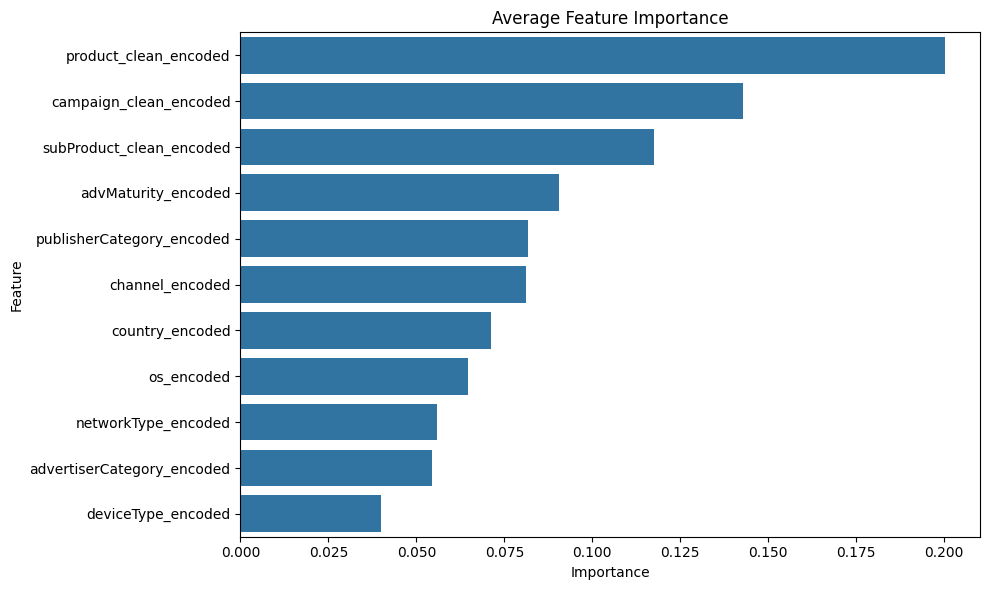

In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

# Define parameter grid for random search
param_distributions = {
    'estimator__n_estimators': randint(100, 1000),
    'estimator__max_depth': randint(3, 10),
    'estimator__learning_rate': uniform(0.01, 0.3),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4),
    'estimator__min_child_weight': randint(1, 7),
    'estimator__gamma': uniform(0, 0.5)
}

# Create base model
base_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
multi_target_model = MultiOutputRegressor(base_model)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multi_target_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X, y)

# Print results
print("\nBest parameters found:")
print(random_search.best_params_)
print("\nBest score:")
print(random_search.best_score_)

# Use the best parameters for your final model
best_model = MultiOutputRegressor(XGBRegressor(
    **{k.replace('estimator__', ''): v 
       for k, v in random_search.best_params_.items()},
    objective='reg:squarederror',
    random_state=42
))

# Optional: Plot feature importance for the best model
def plot_feature_importance(model, feature_names):
    importances = []
    for estimator in model.estimators_:
        importances.append(estimator.feature_importances_)
    
    # Average importance across both models (CTR and CPM)
    avg_importance = np.mean(importances, axis=0)
    
    # Create DataFrame of features and their importance scores
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Average Feature Importance')
    plt.tight_layout()
    plt.show()

# After fitting the best model, plot feature importance
best_model.fit(X, y)
plot_feature_importance(best_model, X.columns)

In [40]:
#Create the final model with best parameters
best_params = {k.replace('estimator__', ''): v 
               for k, v in random_search.best_params_.items()}

# Run the cross-validation with the optimized model
best_model = XGBRegressor(**best_params, objective="reg:squarederror")
multi_target_best = MultiOutputRegressor(best_model)

# Use the same stratified k-fold approach as before
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_binned = pd.qcut(y['CTR_encoded'], q=5, labels=False, duplicates='drop')

mse_scores_ctr = []
mse_scores_cpm = []
r2_scores_ctr = []
r2_scores_cpm = []

# Cross-validation with optimized parameters
for fold_num, (train_index, test_index) in enumerate(skf.split(X, y_binned)):
    print(f"Fold {fold_num + 1}")
    
    X_train_fold = X.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    y_train_fold = y.iloc[train_index]
    y_test_fold = y.iloc[test_index]

    # Train with optimized parameters
    multi_target_best.fit(X_train_fold, y_train_fold)
    y_pred = multi_target_best.predict(X_test_fold)

    # Calculate metrics
    mse_ctr = mean_squared_error(y_test_fold['CTR_encoded'], y_pred[:, 0])
    mse_cpm = mean_squared_error(y_test_fold['AverageWinPrice (CPM)_encoded'], y_pred[:, 1])
    mse_scores_ctr.append(mse_ctr)
    mse_scores_cpm.append(mse_cpm)
    
    r2_ctr = r2_score(y_test_fold['CTR_encoded'], y_pred[:, 0])
    r2_cpm = r2_score(y_test_fold['AverageWinPrice (CPM)_encoded'], y_pred[:, 1])
    r2_scores_ctr.append(r2_ctr)
    r2_scores_cpm.append(r2_cpm)

    print(f"Training size: {len(X_train_fold)}, Validation size: {len(X_test_fold)}")

# Print final results
print("\nFinal Cross-Validation Scores with Optimized Parameters:")
print(f"Average MSE for CTR: {np.mean(mse_scores_ctr):.4f}")
print(f"Average R2 for CTR: {np.mean(r2_scores_ctr):.4f}")
print(f"Average MSE for CPM: {np.mean(mse_scores_cpm):.4f}")
print(f"Average R2 for CPM: {np.mean(r2_scores_cpm):.4f}")

# Compare with previous results
print("\nImprovement from base model:\n")
# Add your previous metrics here for comparison
print("Average MSE for CTR: 0.0043")
print("Average R2 for CTR: 0.1126")
print()
print("Average MSE for CPM: 0.0331") 
print("Average R2 for CPM: 0.6998")


Fold 1
Training size: 243693, Validation size: 60924
Fold 2
Training size: 243693, Validation size: 60924
Fold 3
Training size: 243694, Validation size: 60923
Fold 4
Training size: 243694, Validation size: 60923
Fold 5
Training size: 243694, Validation size: 60923

Final Cross-Validation Scores with Optimized Parameters:
Average MSE for CTR: 0.0037
Average R2 for CTR: 0.2394
Average MSE for CPM: 0.0167
Average R2 for CPM: 0.8483

Improvement from base model:

Average MSE for CTR: 0.0043
Average R2 for CTR: 0.1126

Average MSE for CPM: 0.0331
Average R2 for CPM: 0.6998
